In [101]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow import keras
from keras import layers, applications, utils, models, optimizers, Input, callbacks
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [12]:
def import_dataset(
    dataset_path,
    columns=[
        "distance",
        "sender",
        "distRealSR1",
        "pos_y_rec_f",
        "pos_y_rec",
        "pos_x_rec_f",
        "pos_x_rec",
        "nb_packets_sent",
        "label",
    ],
    data_type={
        "label":"int8"
    }
):
    # Import du csv
    data = pd.read_csv(
        dataset_path,
        usecols=columns,
        index_col=False,
        dtype=data_type
    )

    print("Nombre de lignes avant nettoyage : ", data.shape[0])

    # On remplace les données infinies par nan si elles existent
    data.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Drop les lignes avec nan
    data.dropna(inplace=True)
    print("Nombre de lignes après nettoyage : ", data.shape[0])

    return data

In [6]:
def sample_dataset(dataset, sample_nb):
    return dataset.sample(sample_nb)

In [9]:
def flat_sequence_creation(df):
    senders_sequences = []
    senders_label = []
    senders = np.unique(df["sender"].values)
    for sender in senders:
        # Données d'un seul sender rangée en fonction de l'heure d'envoi
        sender_data_sorted = df.loc[df['sender'] == sender].sort_values("sendTime")

        # On récupère la valeur du label pour ce sender
        label = sender_data_sorted['label'].tolist()[0]
        #On supprime les colonnes label et sender
        sender_data_sorted = sender_data_sorted.drop(["label","sender"], axis=1)
        
        #sequence_array = []

        length = sender_data_sorted.shape[0]
        slide = 10
        start = 0
        end = 20

        # On vérifie qu'il est possible de faire une séquence de taille 20
        while length > 20:
            # Extraction par tranche de 20 avec une inter de 10
            sequence = sender_data_sorted[start:end]

            # Labels correspondant
            #labels =  pd.Series.tolist(sequence["label"])

            # On transforme les 13 en 1, cette formule marche toujours si on met d'autres types d'attaques
            #labels[:] = [x if x == 0 else 1 for x in labels]

            # Attribution des tableaux numpy
            senders_sequences.append(np.array(sequence.values.tolist(), dtype=np.float32))
            senders_label.append(label)

            # Mise à jour des variables
            start += slide
            end += slide
            length -= 10
        
    print('Nombre de séquences : ',len(senders_sequences))
    return senders_sequences, senders_label

In [103]:
selected_columns = [
"nb_packets_sent",
"distance",
"pos_x_send",
"pos_y_send",
"spd_x_send",
"spd_y_send",
"sendTime",
"sender",
"label"
]
df = import_dataset("../data/sample0709.csv",selected_columns)

Nombre de lignes avant nettoyage :  5880000
Nombre de lignes après nettoyage :  5880000


In [104]:
input_sequence_shape = len(selected_columns)-3 # On drop label et sender dans la création de séquences

In [105]:
df_sample = sample_dataset(df, 800000)

In [106]:
df_sample.label.value_counts()

0     387640
13     96250
15     94641
14     94046
18     63810
19     63613
Name: label, dtype: int64

In [107]:
# Ancienne fonction : peu importe l'attaque, le label prend la valeur de 0
sequence, label = flat_sequence_creation(df_sample)

Nombre de séquences :  77917


In [108]:
# Sequences pour multiclasses

labels = [0, 13, 14, 15, 18, 19]
label_encoding = [[1,0,0,0,0,0],
                  [0,1,0,0,0,0],
                  [0,0,1,0,0,0],
                  [0,0,0,1,0,0],
                  [0,0,0,0,1,0],
                  [0,0,0,0,0,1]]
senders_sequences = []
senders_label = []
for idx, label in enumerate(labels):
    # Dataframe ne contenant seulement le label étudié
    df_label_sorted = df_sample.loc[df_sample['label'] == label]

    # Rangement par sender
    senders = np.unique(df_label_sorted["sender"].values)

    for sender in senders:
        # Iteration sur chaque sender
        sender_data_sorted = df_label_sorted.loc[df_label_sorted['sender'] == sender].sort_values("sendTime")

        #On supprime les colonnes label et sender
        sender_data_sorted = sender_data_sorted.drop(["label","sender","sendTime"], axis=1)

        length = sender_data_sorted.shape[0]
        slide = 10
        start = 0
        end = 20

        # On vérifie qu'il est possible de faire une séquence de taille 20
        while length > 20:
            # Extraction par tranche de 20 avec une inter de 10
            sequence = sender_data_sorted[start:end]

            # Attribution des tableaux numpy
            senders_sequences.append(np.array(sequence.values.tolist(), dtype=np.float32))
            senders_label.append(label_encoding[idx])

            # Mise à jour des variables
            start += slide
            end += slide
            length -= 10
print('Nombre de séquences : ',len(senders_sequences))

Nombre de séquences :  75448


In [109]:
sorted_dataset = df.sort_values("sender")

# Transformation en array numpy
X = np.array(senders_sequences)
y = np.array(senders_label, dtype=np.float32)

# Séparation en données d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print("X_train : ", X_train.shape)
print("y_train : ", y_train.shape)
print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

X_train :  (67903, 20, 6)
y_train :  (67903, 6)
X_test :  (7545, 20, 6)
y_test :  (7545, 6)


In [110]:
# Single GRU layer of 256 units
def simple_GRU(input_sequence_shape):
    simple_GRU = keras.models.Sequential()
    simple_GRU.add(
        keras.layers.Dense(
            32, input_shape=(20, input_sequence_shape), activation="relu"
        )
    )
    simple_GRU.add(keras.layers.Dropout(0.2))
    simple_GRU.add(keras.layers.BatchNormalization())
    simple_GRU.add(keras.layers.GRU(256, return_sequences=False, activation="relu"))
    simple_GRU.add(keras.layers.Dropout(0.2))
    simple_GRU.add(keras.layers.BatchNormalization())
    simple_GRU.add( keras.layers.Dense(64, activation='relu') )
    # simple_GRU.add( keras.layers.Dropout(0.2) )
    simple_GRU.add(keras.layers.Dense(6, activation="softmax"))
    return simple_GRU

# 3-stacked GRU model
def stacked_GRU(input_sequence_shape):
    stacked_GRU_model = keras.models.Sequential()
    stacked_GRU_model.add(
        keras.layers.Dense(
            32, input_shape=(20, input_sequence_shape), activation="relu"
        )
    )
    stacked_GRU_model.add(keras.layers.Dropout(0.2))
    stacked_GRU_model.add(keras.layers.BatchNormalization())
    stacked_GRU_model.add(
        keras.layers.GRU(256, return_sequences=True, activation="relu")
    )
    stacked_GRU_model.add(
        keras.layers.GRU(256, return_sequences=True, activation="relu")
    )
    stacked_GRU_model.add(
        keras.layers.GRU(256, return_sequences=False, activation="relu")
    )
    stacked_GRU_model.add(keras.layers.Dropout(0.2))
    stacked_GRU_model.add(keras.layers.BatchNormalization())
    # stacked_GRU_model.add( keras.layers.Dense(64, activation='relu') )
    # stacked_GRU_model.add( keras.layers.Dropout(0.2) )
    stacked_GRU_model.add(keras.layers.Dense(6, activation="sigmoid"))
    return stacked_GRU_model

In [111]:
EPOCHS = 20
VAL_SPLIT = 0.3
ADAM = keras.optimizers.Adam(learning_rate=0.0003)
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [112]:
# simple GRU
simple_GRU_model = simple_GRU(input_sequence_shape)
opt = keras.optimizers.SGD(learning_rate=0.01)
simple_GRU_model.compile(loss='binary_crossentropy', optimizer=opt, metrics='accuracy')
history = simple_GRU_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=64, validation_split=VAL_SPLIT, callbacks=[callback])
# eval=simple_GRU_model.evaluate(X_test, y_test)

Epoch 1/20
743/743 [==============================] - 86s 111ms/step - loss: 0.3109 - accuracy: 0.6308 - val_loss: 0.2331 - val_accuracy: 0.6915
Epoch 2/20
743/743 [==============================] - 82s 110ms/step - loss: 0.2432 - accuracy: 0.6764 - val_loss: 0.2219 - val_accuracy: 0.7017
Epoch 3/20
743/743 [==============================] - 85s 115ms/step - loss: 0.2327 - accuracy: 0.6900 - val_loss: 0.2125 - val_accuracy: 0.7137
Epoch 4/20
743/743 [==============================] - 80s 108ms/step - loss: 0.2245 - accuracy: 0.6995 - val_loss: 0.2208 - val_accuracy: 0.6954
Epoch 5/20
743/743 [==============================] - 83s 112ms/step - loss: 0.2251 - accuracy: 0.6964 - val_loss: 0.2115 - val_accuracy: 0.7096
Epoch 6/20
743/743 [==============================] - 81s 110ms/step - loss: 0.2193 - accuracy: 0.7030 - val_loss: 0.2062 - val_accuracy: 0.7167
Epoch 7/20
743/743 [==============================] - 81s 109ms/step - loss: 0.2149 - accuracy: 0.7105 - val_loss: 0.1999 - val_ac

In [113]:
print(f"Evaluation du modèle : {simple_GRU_model.evaluate(X_test, y_test)}")
y_pred = simple_GRU_model.predict(X_test)

236/236 [==============================] - 5s 20ms/step - loss: 0.1576 - accuracy: 0.7887
Evaluation du modèle : [0.15763604640960693, 0.7887342572212219]
236/236 [==============================] - 5s 18ms/step


In [114]:
preds = np.round(y_pred).astype(int)
preds

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]])

In [115]:
cm = metrics.confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))

Text(33.0, 0.5, 'True Labels')

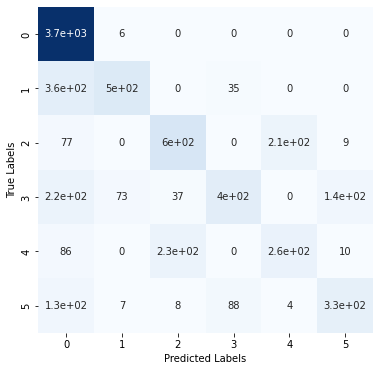

In [116]:
fig, ax = plt.subplots(figsize=(6,6)) 
sns.heatmap(cm, annot=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

In [81]:
stacked_GRU = stacked_GRU(input_sequence_shape)
opt = keras.optimizers.SGD(learning_rate=0.01)
stacked_GRU.compile(loss='categorical_crossentropy', optimizer=opt, metrics='accuracy')
history = stacked_GRU.fit(X_train, y_train, epochs=EPOCHS, batch_size=64, validation_split=VAL_SPLIT, callbacks=[callback])

Epoch 1/20
743/743 [==============================] - 251s 326ms/step - loss: 1.4856 - accuracy: 0.4787 - val_loss: 1.5886 - val_accuracy: 0.4918
Epoch 2/20
743/743 [==============================] - 197s 265ms/step - loss: 1.1060 - accuracy: 0.5859 - val_loss: 3.4145 - val_accuracy: 0.1184
Epoch 3/20
743/743 [==============================] - 189s 255ms/step - loss: 0.9421 - accuracy: 0.6282 - val_loss: 3.9967 - val_accuracy: 0.0701
Epoch 4/20
743/743 [==============================] - 259s 348ms/step - loss: 0.9139 - accuracy: 0.6364 - val_loss: 4.0486 - val_accuracy: 0.0541
Epoch 5/20
231/743 [========>.....................] - ETA: 2:49 - loss: 0.8870 - accuracy: 0.6477

KeyboardInterrupt: 